## Deconvolution
- Note: The following deconvolution process is based on Cell2location, with **SegDecon** providing modifications to hyperparameters at key steps.
- The feature extraction for the scRNA reference is based on the methodology described in the following link: [Cell2location Tutorial – Estimation of Reference Cell Type Signatures (NB Regression)](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html#Estimation-of-reference-cell-type-signatures-(NB-regression)).*

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cell2location
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs
import sys
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## Loading Visium Data Processed by SegDecon  
- (After denoising and segmentation)

In [2]:
adata_st = sc.read_h5ad('../0502stardist_nuclei_c2linput.h5ad')
adata_st

AnnData object with n_obs × n_vars = 6965 × 19465
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'nuclei_count'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
adata_st.var["feature_name"] = adata_st.var_names
adata_st.var.set_index("gene_ids", drop=True, inplace=True)
adata_st.var.head()

feature_types genome     mt  n_cells_by_counts  \
gene_ids                                                               
ENSMUSG00000051951  Gene Expression   mm10  False               2836   
ENSMUSG00000025900  Gene Expression   mm10  False                 12   
ENSMUSG00000025902  Gene Expression   mm10  False               1600   
ENSMUSG00000025903  Gene Expression   mm10  False               4371   
ENSMUSG00000033813  Gene Expression   mm10  False               4679   

                    mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
gene_ids                                                                    
ENSMUSG00000051951     0.714142           0.538913              59.282125   
ENSMUSG00000025900     0.001866           0.001865              99.827710   
ENSMUSG00000025902     0.290739           0.255215              77.027997   
ENSMUSG00000025903     1.243216           0.807911              37.243360   
ENSMUSG00000033813     1.571285           0.944406              32.821249   

                    total_counts  log1p_total_counts feature_name  
gene_ids                                                           
ENSMUSG00000051951        4974.0            8.512180         Xkr4  
ENSMUSG00000025900          13.0            2.639057          Rp1  
ENSMUSG00000025902        2025.0            7.613819        Sox17  
ENSMUSG00000025903        8659.0            9.066470       Lypla1  
ENSMUSG00000033813       10944.0            9.300638        Tcea1

In [4]:
# find mitochondria-encoded (MT) genes
adata_st.var['MT_gene'] = [gene.startswith('mt-') for gene in adata_st.var.index]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_st.obsm['MT'] = adata_st[:, adata_st.var['MT_gene'].values].X.toarray()
adata_st = adata_st[:, ~adata_st.var['MT_gene'].values]
adata_st

View of AnnData object with n_obs × n_vars = 6965 × 19465
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'nuclei_count'
    var: 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'feature_name', 'MT_gene'
    uns: 'spatial'
    obsm: 'spatial', 'MT'

## Loading scRNA-seq reference data   
It based on the methodology described in the following link: [Cell2location Tutorial – Estimation of Reference Cell Type Signatures (NB Regression)](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html#Estimation-of-reference-cell-type-signatures-(NB-regression)).

In [5]:
results_folder = '../../results/mouse_brain_snrna/'

regression_model_output = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

os.makedirs(reg_path, exist_ok=True)

## snRNAseq reference (raw counts)
adata_ref = sc.read(f'{reg_path}sc.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 40532 × 12819
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1', 'n_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean', 'mean', 'std'
    uns: 'annotation_1_colors', 'neighbors', 'pca', 'regression_mod', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Interact scRNA-seq data and visium data to one dataset.

In [6]:
adata_sc = adata_ref
shared_features = [
    feature for feature in adata_st.var_names if feature in adata_sc.var_names
]
adata_sc = adata_sc[:, shared_features].copy()
adata_st = adata_st[:, shared_features].copy()

covariate_col_names = 'annotation_1'

inf_aver = adata_ref.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_ref.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_ref.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_ref.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

## Spatial Mapping  

### **Model Hyperparameters**  

- **N_cells_per_location** is a key hyperparameter of the model, defining the global prior for the number of cells per spatial location. It is essential to adapt this parameter to each specific tissue. The observed value in a given dataset reflects the average number of cells per spot in the spatial transcriptomics data.  

- **N_cells_mean_var_ratio** accounts for the variance in cell abundance within the dataset, adjusting the prior accordingly.  

### **Computation of Mean and Variance from `adata_st.obs`**  

> *Note: Here, `adata_st` is derived from SegDecon and contains the `['nuclei_count']` information.*  

```python
mean_cells = adata_st.obs['nuclei_count'].mean()  # Using the observed mean as the prior
var_cells = adata_st.obs['nuclei_count'].var()  # Adjusting prior variance 


In [7]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_st.var_names, inf_aver.index)
adata_st = adata_st[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# Convert the data to float32
adata_st.obs['nuclei_count'] = adata_st.obs['nuclei_count'].astype('float32')
# Compute mean and variance from adata.obs
mean_cells = adata_st.obs['nuclei_count'].mean().astype('float32')
var_cells = adata_st.obs['nuclei_count'].var().astype('float32')

N_cells_mean_var_ratio = mean_cells /var_cells
print(f"N_cells_mean_var_ratio: {N_cells_mean_var_ratio:.2f}")

print(f"mean_cells: {mean_cells:.2f}")
print(f"var_cells: {var_cells:.2f}")

N_cells_mean_var_ratio: 0.06
mean_cells: 20.21
var_cells: 350.00


In [8]:
import cell2location as c2l
c2l.models.Cell2location.setup_anndata(
    adata=adata_st,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:
# Update model initialization parameters
# Ensure model parameters are also float32
model = c2l.models.Cell2location(
    adata_st,
    cell_state_df=inf_aver,
    N_cells_per_location=float(mean_cells),  # 使用 float32
    N_cells_mean_var_ratio=float(N_cells_mean_var_ratio),  # 使用 float32
    detection_alpha=20
)
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.6.post2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 6965  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10834 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30000/30000: 100%|█| 30000/30000 [1:03:25<00:00,  7.69it/s, v_num=1, elbo_

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [1:03:25<00:00,  7.88it/s, v_num=1, elbo_


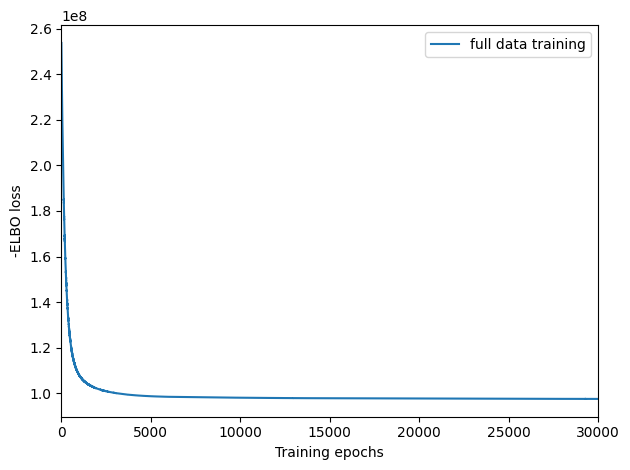

In [10]:
model.train(max_epochs=30000, batch_size=None, train_size=1)
# plot training history
model.plot_history()
plt.legend(labels=['full data training']);

In [11]:
adata_st = model.export_posterior(
    adata_st,
    sample_kwargs={
        "num_samples": 1000,
        "batch_size": model.adata.n_obs,
    },
)

Sampling global variables, sample: 100%|██████| 999/999 [00:27<00:00, 36.62it/s]


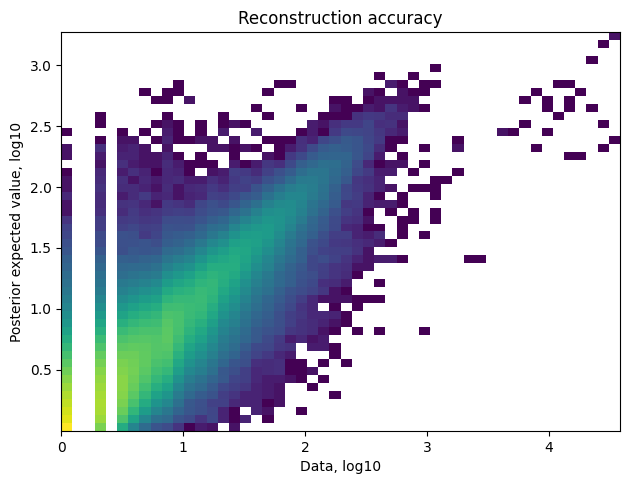

In [12]:
model.plot_QC()

In [13]:
adata_st.obsm

AxisArrays with keys: spatial, MT, means_cell_abundance_w_sf, stds_cell_abundance_w_sf, q05_cell_abundance_w_sf, q95_cell_abundance_w_sf

In [14]:
pd.DataFrame(adata_st.obsm['q05_cell_abundance_w_sf']).to_csv("../../cell2location_map/newsample_st_cell2location_res.csv")

adata_st.obs[adata_st.uns["mod"]["factor_names"]] = adata_st.obsm[
    "q05_cell_abundance_w_sf"
]

## Visualising cell abundance in spatial coordinates

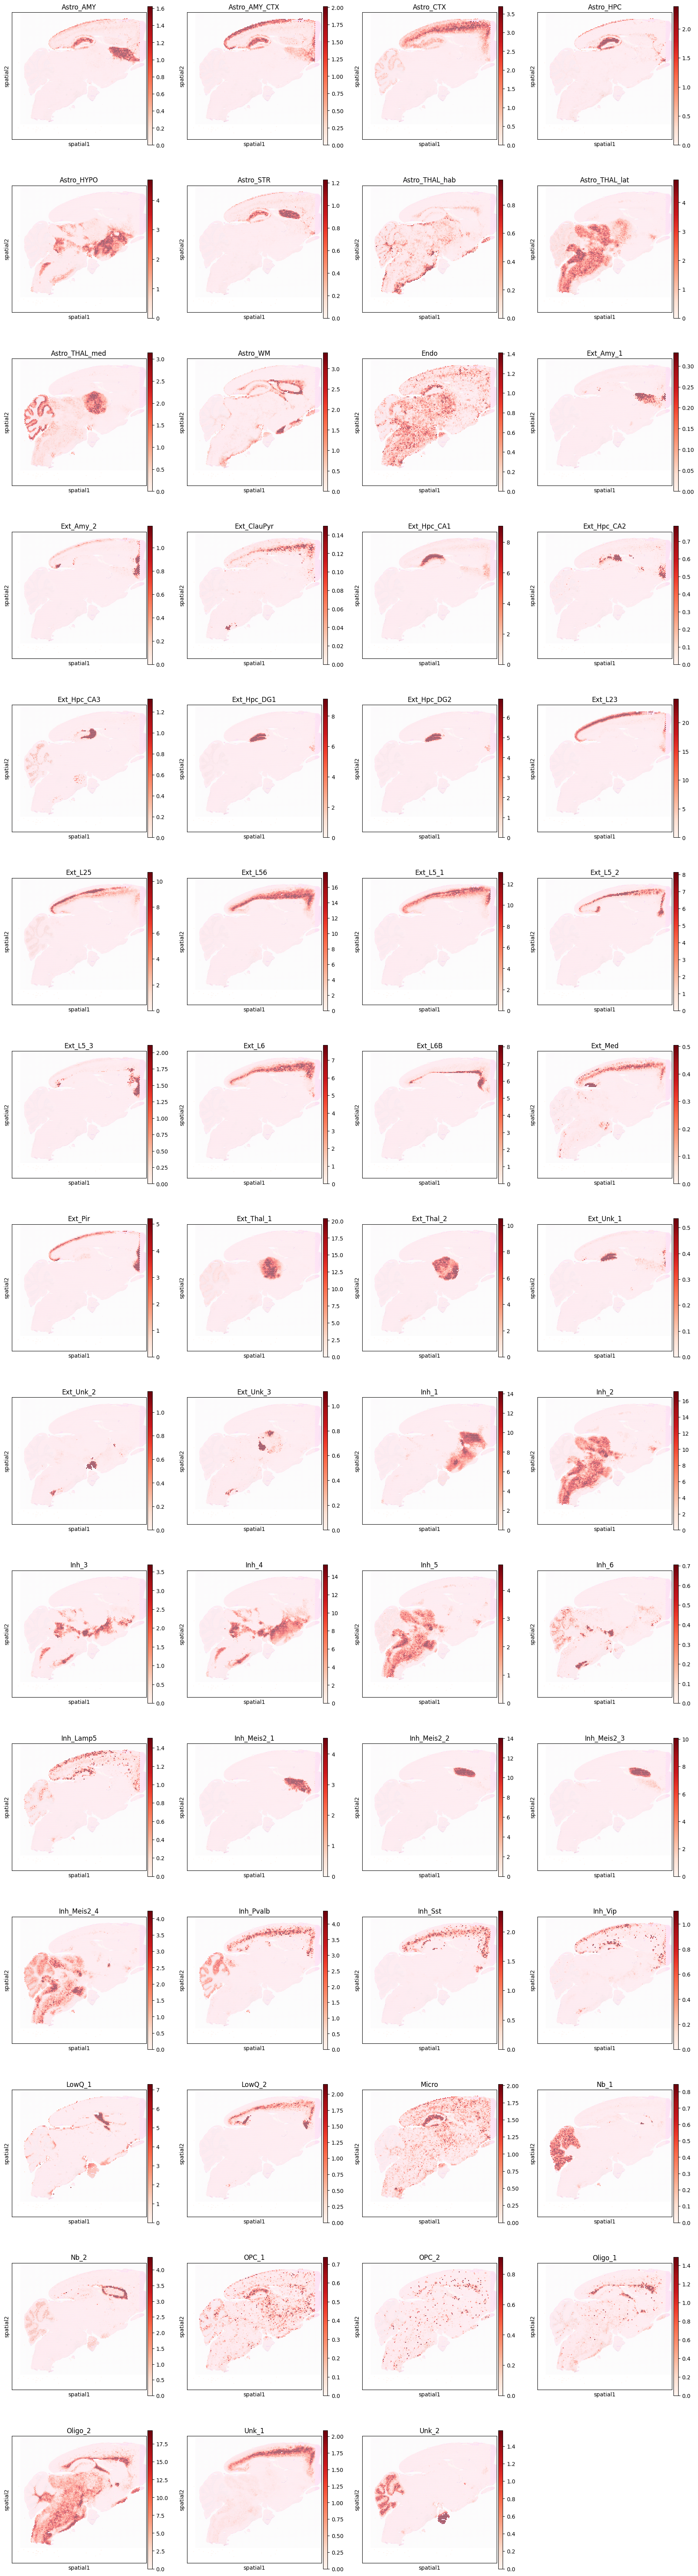

In [15]:
import matplotlib

with matplotlib.rc_context({"figure.figsize": [4.5, 5]}):
    sc.pl.spatial(
        #slide,
        adata_st,
        cmap="Reds",
        color=adata_st.uns["mod"]["factor_names"],
        ncols=4,
        size=1.3,
        img_key="hires",
        # limit color scale at 99.2% quantile of cell abundance
        vmin=0,
        vmax="p99.2",
        alpha_img=0.2,
    )

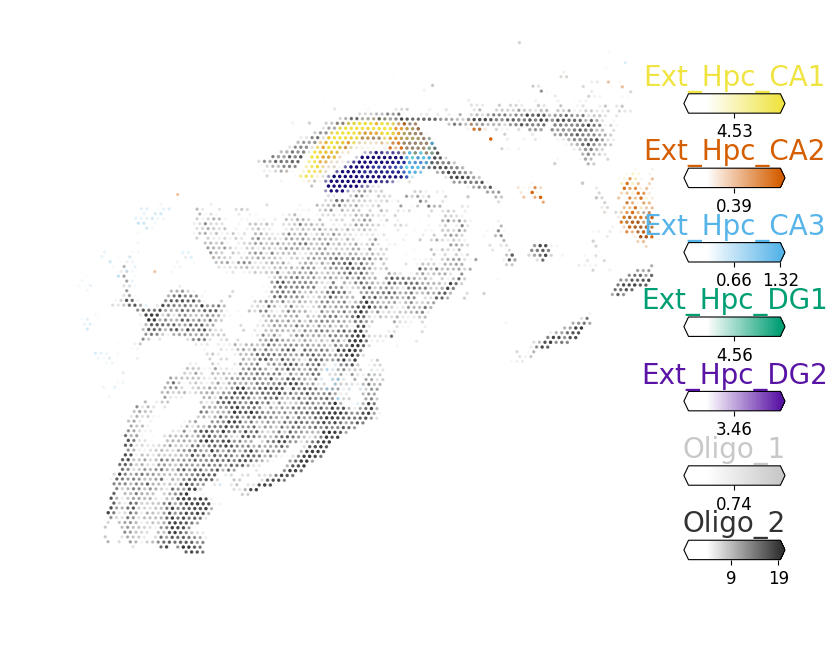

In [16]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Ext_Hpc_CA1','Ext_Hpc_CA2','Ext_Hpc_CA3','Ext_Hpc_DG1','Ext_Hpc_DG2','Oligo_1','Oligo_2']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

#slide = select_slide(adata_st, 'V1_Human_Lymph_Node')

with matplotlib.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata=adata_st,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=False,
        img_key='lowres',
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=1.5,
        colorbar_position='right'
    )
plt.show()

In [17]:
adata_st.write("0502newsample_c2loutput.h5ad")

In [2]:
!jupyter nbconvert --to script "./02c2l-bigger-Copy1.ipynb"

[NbConvertApp] Converting notebook ./02c2l-bigger.ipynb to script
[NbConvertApp] Writing 11264 bytes to 02c2l-bigger.py


## Modules and their versions used for this analysis
Useful for debugging and reporting issues.

In [18]:
cell2location.utils.list_imported_modules()

sys 3.9.18 (main, Nov 15 2023, 04:22:28) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-20)]
re 2.2.1
ipykernel._version 6.29.5
json 2.0.9
jupyter_client._version 8.6.3
platform 1.0.8
zmq.sugar.version 26.2.0
zmq.sugar 26.2.0
zmq 26.2.0
logging 0.5.1.2
traitlets._version 5.14.3
traitlets 5.14.3
jupyter_core.version 5.7.2
jupyter_core 5.7.2
tornado 6.4.1
zlib 1.0
_curses b'2.2'
socketserver 0.4
argparse 1.1
dateutil._version 2.9.0.post0
dateutil 2.9.0.post0
six 1.16.0
_decimal 1.70
decimal 1.70
platformdirs.version 4.3.6
platformdirs 4.3.6
jupyter_client 8.6.3
ipykernel 6.29.5
IPython.core.release 8.18.1
executing.version 2.1.0
executing 2.1.0
pure_eval.version 0.2.3
pure_eval 0.2.3
stack_data.version 0.6.3
stack_data 0.6.3
pygments 2.18.0
_csv 1.0
csv 1.0
ptyprocess 0.7.0
pexpect 4.9.0
IPython.core.crashhandler 8.18.1
decorator 5.1.1
_sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
sqlite3 2.6.0
exceptiongroup._version 1.2.2
exceptiongroup 1.2.2
wcwidth 0.2.13
prompt_toolkit 3.0.47
parso 0.8.4
jedi 0.19.1
url